# Assessment of Ethan Zheng's Problem 4

## Part 1

In [7]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt

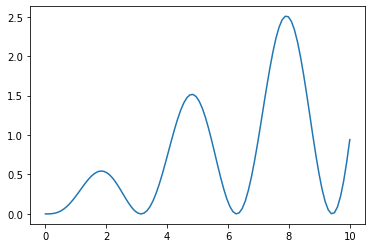

In [9]:
def objective(x):
    return torch.square(torch.sin(x))*x/np.pi
X = torch.linspace(0,10,100)
plt.plot(X, objective(X))

## Part 2

In [20]:
train_x = torch.tensor(np.random.choice(X, 3))
train_x = train_x.unsqueeze(1)
train_x

tensor([[6.4646],
        [3.6364],
        [0.2020]])

In [148]:
train_y = objective(train_x)

from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan
model = SingleTaskGP(
    train_X=train_x,
    train_Y=train_y,
    covar_module=gpytorch.kernels.RBFKernel()
)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
mll = mll.to(train_x)

optimizer = torch.optim.SGD([{'params': model.parameters()}], lr=.1)

NUM_EPOCHS = 300

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, model.train_targets)
    loss.backward()
    optimizer.step()

def get_and_fit_model(Xs, Ys):
    train_X, train_Y = Xs, Ys.unsqueeze(1)
    model = model = SingleTaskGP(
        train_X=train_X,
        train_Y=train_Y,
        covar_module=gpytorch.kernels.RBFKernel(1)
    )
    model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
    model.train()
    
    optimizer = torch.optim.SGD([{'params': model.parameters()}], lr=.1)
    
    NUM_EPOCHS = 300

    for epoch in range(NUM_EPOCHS):
        optimizer.zero_grad()
        output = model(train_X)
        loss = -mll(output, model.train_targets)
        loss.backward()
        optimizer.step()
    return model

def get_new_observation(model):
    model.eval()
    test_x = torch.linspace(0,10,100)
    with torch.no_grad():
        posterior = model.posterior(test_x)
        sample = post.sample()
        sMax = torch.max(sample,1)
#         print(sMax)
        newIn = torch.cat([model.train_inputs[0], test_x[sMax[1]]])
#         print(newIn)
        newOut = torch.cat([model.train_targets, sMax[0][0]])
        return newIn,newOut

## Part 3

In [149]:
for i in range(10):
    print(i)
    Xs, Ys = get_new_observation(model)
#     print(Xs)
    model = get_and_fit_model(Xs, Ys)
#     print(model.train_inputs)

0
1
2
3
4
5
6
7
8
9


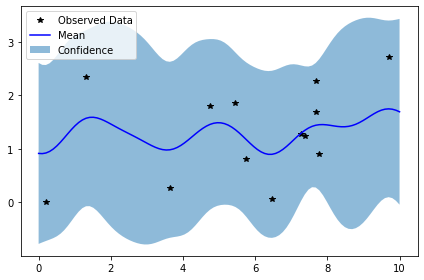

In [150]:
model.eval()
%matplotlib inline

f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(0, 10, 100)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(model.train_inputs[0].cpu().numpy(), model.train_targets.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()

# Reflection

This question was a good way to test the skills I've learned in GPyTorch and BoTorch, but there definitely could have been more explanation. I'm honestly not sure why my results were bad, and I would appreciate any advice as to where I went wrong.